# Neural Ordinary Differential Equations — Spiral Dynamics Lab
**Learning objectives**
- Connect residual networks to continuous-depth dynamics by taking the limit of $h_{t+1} = h_t + \Delta t\,f_\theta(h_t, t)$ as $\Delta t \to 0$
- Understand how the adjoint state $a(t)$ with dynamics $\dot{a} = -\left(\partial f_\theta / \partial h\right)^{\top} a$ yields $\mathcal{O}(1)$-memory training
- Reproduce the cubic spiral system defined by $\dot{z} = A (z \odot z \odot z)$ and its mini-batch data loader
- Compare solvers, tolerances, and adjoint tricks to design Neural ODE exercises analogous to the PINNs / DeepONet modules


[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kks32-courses/sciml/blob/main/docs/07-neural-ode/neural-ode.ipynb)


## 1. From residual blocks to continuous depth
A ResNet layer computes
$$h_{t+1} = h_t + f_\theta(h_t),$$
which is exactly a forward-Euler update of the autonomous ODE $\frac{dh}{dt} = f_\theta(h)$. Letting the layer spacing $\Delta t \to 0$ gives the flow map
$$\phi_{t_0 \to t_1}(h_0) = h_0 + \int_{t_0}^{t_1} f_\theta(h(t), t)\,dt,$$
so deep residual blocks become continuous-depth dynamics. This notebook follows the same pattern used throughout the course: build intuition, implement the model, then explore experiments.


## 2. Adjoint method recap
To differentiate through an ODE solver efficiently, introduce the adjoint state $a(t) = \partial \mathcal{L}/\partial h(t)$ and the Hamiltonian $\mathcal{H}(h, a, t) = a^{\top} f_\theta(h, t)$. Differentiating the objective with Lagrange multipliers produces the coupled backward dynamics
$$\dot{a}(t) = -\left(\frac{\partial f_\theta}{\partial h}(h(t), t)\right)^{\top} a(t),$$
with terminal condition $a(t_1) = \partial \mathcal{L}/\partial h(t_1)$. Integrating $h(t)$ forward and $(h(t), a(t))$ backward yields gradients while storing only the current state, giving $\mathcal{O}(1)$ memory regardless of the number of solver steps. We expose both `odeint` and `odeint_adjoint` so you can compare their runtime/memory trade-offs.


## Variational inference and the ELBO (primer)
Latent Neural ODEs and function encoders augment the basic setup with latent variables $z$. The generative model samples $z_0 \sim p(z_0)$, evolves it via $\dot{z} = f_\theta(z, t)$, and decodes observations with $p(x_t \mid z_t)$. Because the exact posterior $p(z_0 \mid x_{1:T})$ is intractable, we introduce an encoder distribution $q_\phi(z_0 \mid x_{1:T})$ and optimize the evidence lower bound:
$$\log p(x_{1:T}) \ge \mathbb{E}_{q_\phi(z_0 \mid x_{1:T})}\left[\log p_\theta(x_{1:T} \mid z_{1:T})\right] - \mathrm{KL}\big(q_\phi(z_0 \mid x_{1:T}) \parallel p(z_0)\big).$$
The first term is a reconstruction log-likelihood, while the second regularizes the inferred initial condition toward the prior. This variational perspective is used directly in the latent-ODE and zero-shot notebooks, so we keep the equations handy here for reference.


## 3. Environment setup
The original `torchdiffeq` repo sits in `docs/07-neural-ode/torchdiffeq`. The helper cell below wires it into `sys.path`, sets deterministic seeds, and establishes some visualization defaults.


In [1]:
import math
import sys
import time
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

plt.style.use('seaborn-v0_8')
plt.rcParams.update({'figure.figsize': (6, 4), 'axes.grid': True})

REPO_ROOT = Path.cwd()
TORCHDIFFEQ_DIR = (REPO_ROOT / 'docs' / '07-neural-ode' / 'torchdiffeq').resolve()
if TORCHDIFFEQ_DIR.exists() and str(TORCHDIFFEQ_DIR) not in sys.path:
    sys.path.insert(0, str(TORCHDIFFEQ_DIR))

from torchdiffeq import odeint, odeint_adjoint


In [2]:
def set_seed(seed: int = 42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(0)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE


device(type='cpu')

## 4. Ground-truth spiral system (Section 5.1 example)
The spiral benchmark uses the cubic vector field $\dot{z} = A z^3$ with
$$A = \begin{bmatrix}-0.1 & 2.0\\ -2.0 & -0.1\end{bmatrix}.$$
We integrate it with a high-accuracy Dormand–Prince solver (`dopri5`) to create the supervised learning target. Batches contain short trajectory snippets, mimicking the training protocol from `torchdiffeq/examples/ode_demo.py`.


In [3]:
DATA_SIZE = 1000
T_END = 25.0
BATCH_TIME = 10
BATCH_SIZE = 20
true_y0 = torch.tensor([[2.0, 0.0]], device=DEVICE)
t = torch.linspace(0.0, T_END, DATA_SIZE, device=DEVICE)
true_A = torch.tensor([[-0.1, 2.0], [-2.0, -0.1]], device=DEVICE)

class SpiralDynamics(nn.Module):
    def forward(self, t, y):
        return torch.mm(y**3, true_A)

with torch.no_grad():
    gt_solver = SpiralDynamics().to(DEVICE)
    true_y = odeint(gt_solver, true_y0, t, method='dopri5')
true_y.shape


torch.Size([1000, 1, 2])

In [ ]:
def sample_batch(batch_size=BATCH_SIZE, batch_time=BATCH_TIME):
    start_ids = np.random.choice(np.arange(DATA_SIZE - batch_time), size=batch_size, replace=False).astype(np.int64)
    start_ids_tensor = torch.from_numpy(start_ids).long().to(DEVICE)
    batch_y0 = true_y[start_ids_tensor]
    batch_t = t[:batch_time]
    batch_y = torch.stack([true_y[start_ids_tensor + i] for i in range(batch_time)], dim=0)
    return batch_y0, batch_t.to(DEVICE), batch_y, start_ids_tensor


def to_numpy(tensor):
    return tensor.detach().cpu().numpy()


def plot_phase(traj, reference=None, title='Phase portrait'):
    traj_np = to_numpy(traj)
    plt.figure(figsize=(6, 5))
    plt.plot(traj_np[:, 0, 0], traj_np[:, 0, 1], label='trajectory', linewidth=2)
    if reference is not None:
        ref_np = to_numpy(reference)
        plt.plot(ref_np[:, 0, 0], ref_np[:, 0, 1], '--', label='reference')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)
    plt.legend()
    plt.axis('equal')
    plt.show()


def plot_time_series(times, traj, reference=None, title='State vs time'):
    t_np = to_numpy(times)
    traj_np = to_numpy(traj)
    plt.figure(figsize=(7, 4))
    plt.plot(t_np, traj_np[:, 0, 0], label='x(t)')
    plt.plot(t_np, traj_np[:, 0, 1], label='y(t)')
    if reference is not None:
        ref_np = to_numpy(reference)
        plt.plot(t_np, ref_np[:, 0, 0], '--', label='x true')
        plt.plot(t_np, ref_np[:, 0, 1], '--', label='y true')
    plt.xlabel('time')
    plt.ylabel('state value')
    plt.title(title)
    plt.legend()
    plt.show()


### Visualize the supervised signal


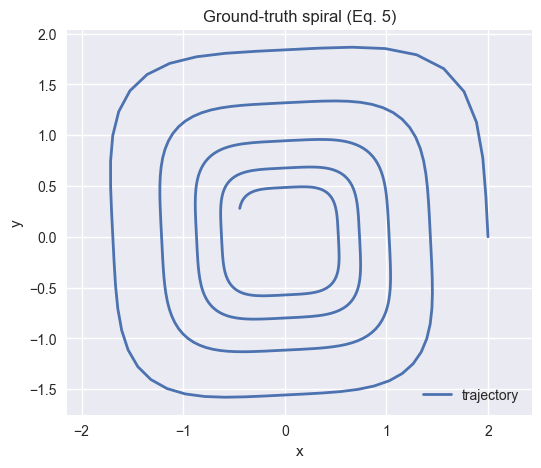

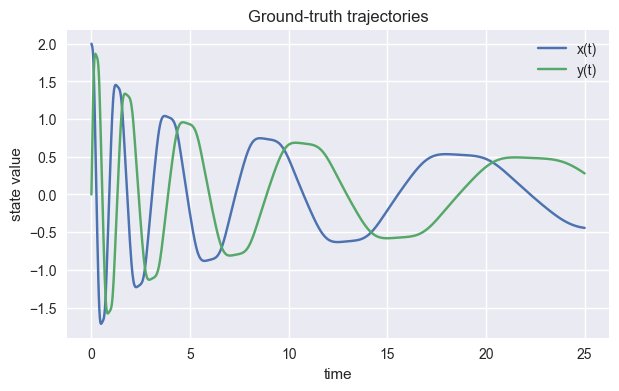

In [5]:
plot_phase(true_y, title='Ground-truth spiral (cubic system)')
plot_time_series(t, true_y, title='Ground-truth trajectories')


## 5. Neural ODE parametrization
We learn a neural vector field $f_\theta(z)$ such that $\dot{z} = f_\theta(z)$ matches the true system. The function is a small MLP following the architecture in the paper (50 hidden units + Tanh). We wrap it in a `NeuralODEModel` that can use either `odeint` or `odeint_adjoint`.


In [6]:
class ODEFunc(nn.Module):
    def __init__(self, hidden_dim=50):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 2)
        )
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=0.1)
                nn.init.zeros_(m.bias)

    def forward(self, t, y):
        return self.net(y**3)


class NeuralODEModel(nn.Module):
    def __init__(self, hidden_dim=50, method='dopri5', rtol=1e-5, atol=1e-6, use_adjoint=False):
        super().__init__()
        self.func = ODEFunc(hidden_dim)
        self.method = method
        self.rtol = rtol
        self.atol = atol
        self.use_adjoint = use_adjoint

    def forward(self, y0, t_eval):
        solver = odeint_adjoint if self.use_adjoint else odeint
        return solver(self.func, y0, t_eval, method=self.method, rtol=self.rtol, atol=self.atol)


## 6. Training utilities
Following the paper, we optimize the $L_1$ loss between predicted and true trajectories. Each iteration samples a mini-batch of time windows so the model learns local dynamics instead of memorizing one trajectory. Logs store both batch losses and full-trajectory validation losses for plotting.


In [7]:
def train_neural_ode(model, num_iters=1500, lr=1e-3, eval_freq=100):
    optimizer = optim.RMSprop(model.parameters(), lr=lr)
    history = []
    batch_losses = []
    start = time.time()
    for itr in range(1, num_iters + 1):
        model.train()
        optimizer.zero_grad()
        batch_y0, batch_t, batch_y, _ = sample_batch()
        pred_y = model(batch_y0, batch_t)
        loss = torch.mean(torch.abs(pred_y - batch_y))
        loss.backward()
        optimizer.step()

        batch_losses.append(loss.item())

        if itr % eval_freq == 0:
            model.eval()
            with torch.no_grad():
                pred_full = model(true_y0, t)
                eval_loss = torch.mean(torch.abs(pred_full - true_y)).item()
            history.append({'iter': itr, 'train_loss': loss.item(), 'eval_loss': eval_loss})
            print(f"Iter {itr:04d} | batch L1 {loss.item():.5f} | full traj L1 {eval_loss:.5f}")
    elapsed = time.time() - start
    return {'history': history, 'batch_losses': batch_losses, 'elapsed': elapsed}


## 7. Fit the neural ODE


In [8]:
set_seed(1)
neural_ode = NeuralODEModel(hidden_dim=64, method='dopri5', rtol=1e-5, atol=1e-6, use_adjoint=False).to(DEVICE)
training_stats = train_neural_ode(neural_ode, num_iters=1500, eval_freq=100)
training_stats['elapsed']


Iter 0100 | batch L1 0.00318 | full traj L1 0.64803
Iter 0200 | batch L1 0.01523 | full traj L1 0.26140
Iter 0300 | batch L1 0.00291 | full traj L1 0.21827
Iter 0400 | batch L1 0.00382 | full traj L1 0.20259
Iter 0500 | batch L1 0.00124 | full traj L1 0.60218
Iter 0600 | batch L1 0.01859 | full traj L1 0.69813
Iter 0700 | batch L1 0.00621 | full traj L1 0.22878
Iter 0800 | batch L1 0.00368 | full traj L1 0.28749
Iter 0900 | batch L1 0.00699 | full traj L1 0.30684
Iter 1000 | batch L1 0.00188 | full traj L1 0.25110
Iter 1100 | batch L1 0.00130 | full traj L1 0.19739
Iter 1200 | batch L1 0.00362 | full traj L1 0.58730
Iter 1300 | batch L1 0.00065 | full traj L1 0.32579
Iter 1400 | batch L1 0.00146 | full traj L1 0.31774
Iter 1500 | batch L1 0.01064 | full traj L1 0.13111


6.708943843841553

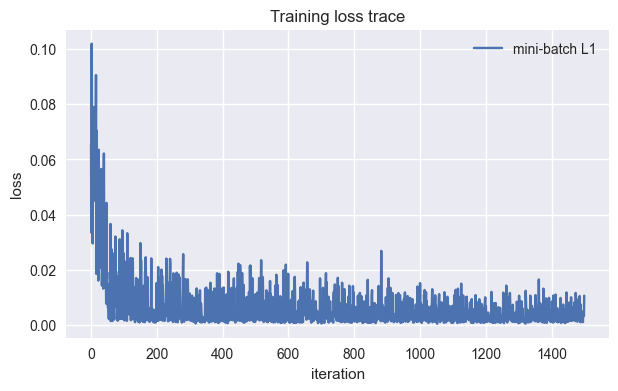

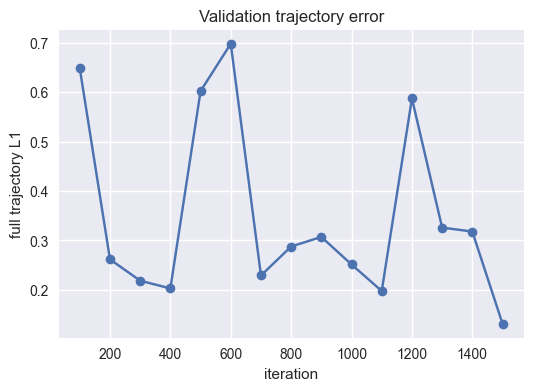

In [9]:
plt.figure(figsize=(7, 4))
plt.plot(training_stats['batch_losses'], label='mini-batch L1')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('Training loss trace')
plt.legend()
plt.show()

iters = [h['iter'] for h in training_stats['history']]
full_losses = [h['eval_loss'] for h in training_stats['history']]
plt.figure(figsize=(6, 4))
plt.plot(iters, full_losses, marker='o')
plt.xlabel('iteration')
plt.ylabel('full trajectory L1')
plt.title('Validation trajectory error')
plt.show()


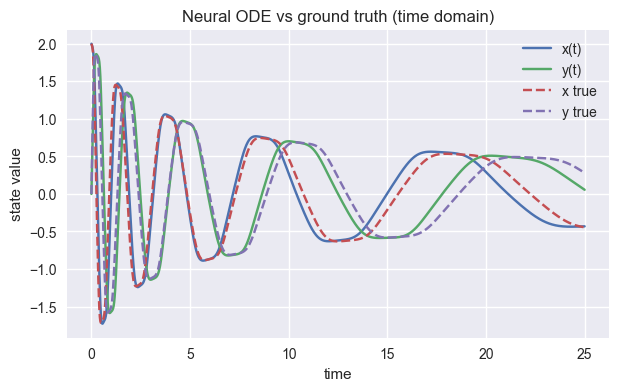

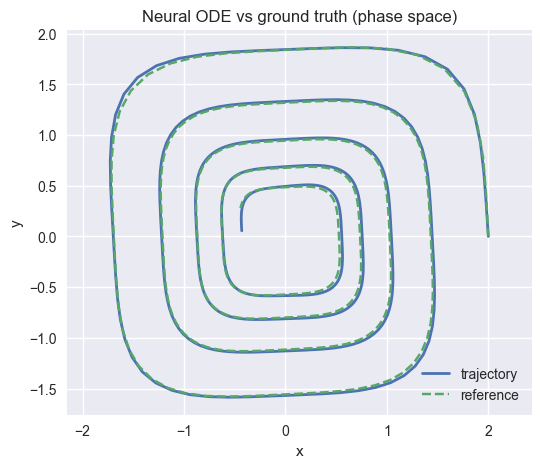

In [10]:
neural_ode.eval()
with torch.no_grad():
    pred_traj = neural_ode(true_y0, t)
plot_time_series(t, pred_traj, reference=true_y, title='Neural ODE vs ground truth (time domain)')
plot_phase(pred_traj, reference=true_y, title='Neural ODE vs ground truth (phase space)')


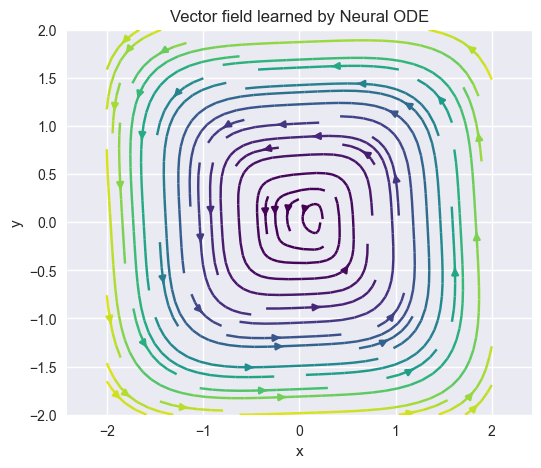

In [11]:
def plot_vector_field(func, title='Learned vector field'):
    grid_x = np.linspace(-2, 2, 25)
    grid_y = np.linspace(-2, 2, 25)
    X, Y = np.meshgrid(grid_x, grid_y)
    grid = torch.tensor(np.stack([X, Y], axis=-1).reshape(-1, 2), dtype=torch.float32, device=DEVICE)
    with torch.no_grad():
        vec = func(0, grid).detach().cpu().numpy()
    U = vec[:, 0].reshape(X.shape)
    V = vec[:, 1].reshape(Y.shape)
    plt.figure(figsize=(6, 5))
    plt.streamplot(X, Y, U, V, color=np.hypot(U, V), cmap='viridis')
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.axis('equal')
    plt.show()

plot_vector_field(neural_ode.func, title='Vector field learned by Neural ODE')


## 8. Fixed-step ResNet baseline
To mirror the pedagogical approach in the PINNs/DeepONet modules, we compare against a discrete residual network that performs explicit-Euler updates with a learned $f_\theta$. Unlike the Neural ODE, it cannot adapt step sizes or evaluate at arbitrary timestamps, so extrapolation should degrade.


In [12]:
class FixedStepResNet(nn.Module):
    def __init__(self, hidden_dim=64, max_steps=2000):
        super().__init__()
        self.blocks = nn.ModuleList([self._make_block(hidden_dim) for _ in range(max_steps)])

    @staticmethod
    def _make_block(hidden_dim):
        block = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 2)
        )
        for m in block.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, a=math.sqrt(5))
                nn.init.zeros_(m.bias)
        return block

    def forward(self, y0, t_eval, start_indices=None):
        if start_indices is None:
            start_indices = torch.zeros(y0.shape[0], dtype=torch.long, device=y0.device)
        traj = [y0]
        y = y0
        times = t_eval.to(y0.device)
        for step in range(1, times.shape[0]):
            dt = float((times[step] - times[step - 1]).item())
            next_states = []
            for b in range(y.shape[0]):
                layer_idx = int(start_indices[b].item()) + step - 1
                if layer_idx >= len(self.blocks):
                    raise IndexError(f"Layer index {layer_idx} exceeds available blocks")
                block = self.blocks[layer_idx]
                current = y[b]
                update = block(current.view(1, -1)).view_as(current)
                next_states.append(current + update * dt)
            y = torch.stack(next_states, dim=0)
            traj.append(y)
        return torch.stack(traj)


def train_resnet(model, num_iters=1500, lr=1e-3, eval_freq=100):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    history = []
    for itr in range(1, num_iters + 1):
        optimizer.zero_grad()
        batch_y0, batch_t, batch_y, start_idx = sample_batch()
        pred = model(batch_y0, batch_t, start_indices=start_idx)
        loss = torch.mean(torch.abs(pred - batch_y))
        loss.backward()
        optimizer.step()
        if itr % eval_freq == 0:
            with torch.no_grad():
                zero_idx = torch.zeros(true_y0.shape[0], dtype=torch.long, device=DEVICE)
                pred_full = model(true_y0, t, start_indices=zero_idx)
                eval_loss = torch.mean(torch.abs(pred_full - true_y)).item()
            history.append({'iter': itr, 'eval_loss': eval_loss})
            print(f"[ResNet] Iter {itr:04d} | full traj L1 {eval_loss:.5f}")
    return history


In [13]:
set_seed(2)
resnet_model = FixedStepResNet(hidden_dim=64).to(DEVICE)
resnet_history = train_resnet(resnet_model, num_iters=1200, eval_freq=100)


[ResNet] Iter 0100 | full traj L1 0.60406
[ResNet] Iter 0200 | full traj L1 0.57690
[ResNet] Iter 0300 | full traj L1 0.52968
[ResNet] Iter 0400 | full traj L1 0.56203
[ResNet] Iter 0500 | full traj L1 0.51307
[ResNet] Iter 0600 | full traj L1 0.55428
[ResNet] Iter 0700 | full traj L1 0.59355
[ResNet] Iter 0800 | full traj L1 0.51762
[ResNet] Iter 0900 | full traj L1 0.55515
[ResNet] Iter 1000 | full traj L1 0.59169
[ResNet] Iter 1100 | full traj L1 0.53287
[ResNet] Iter 1200 | full traj L1 0.62170


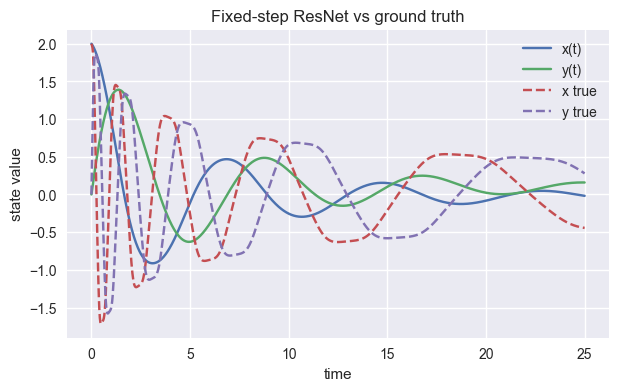

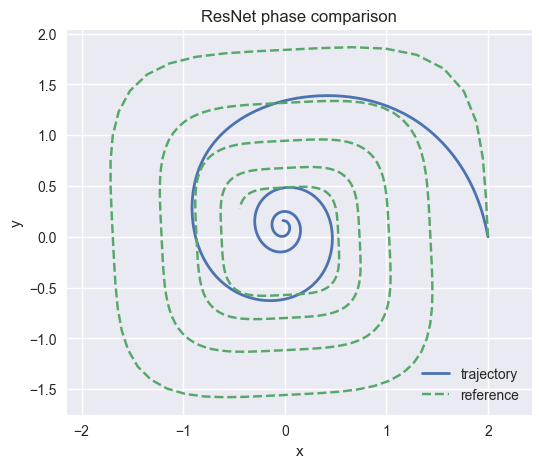

In [14]:
with torch.no_grad():
    zero_idx = torch.zeros(true_y0.shape[0], dtype=torch.long, device=DEVICE)
    resnet_traj = resnet_model(true_y0, t, start_indices=zero_idx)
plot_time_series(t, resnet_traj, reference=true_y, title='Fixed-step ResNet vs ground truth')
plot_phase(resnet_traj, reference=true_y, title='ResNet phase comparison')


### Extrapolation stress test
Zero-shot Neural ODE studies emphasize evaluating at unseen time horizons. We extend the time grid to $t=35$ and reuse both models without retraining.


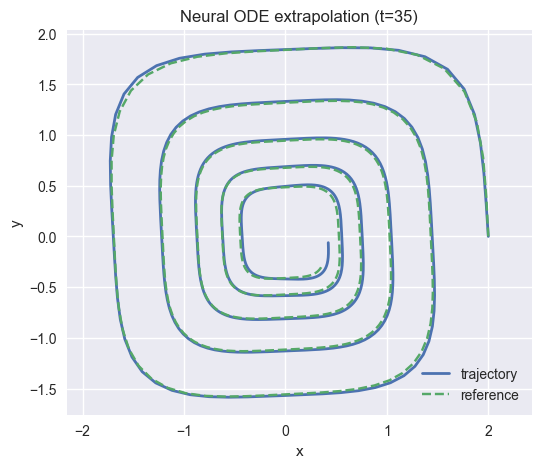

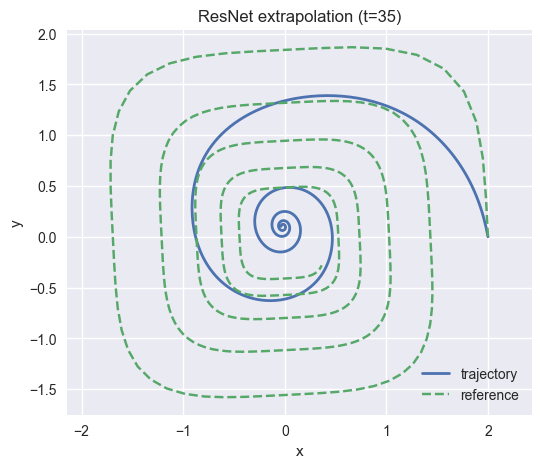

In [15]:
t_long = torch.linspace(0.0, 35.0, 1400, device=DEVICE)
with torch.no_grad():
    true_long = odeint(gt_solver, true_y0, t_long, method='dopri5')
    ode_long = neural_ode(true_y0, t_long)
    zero_idx = torch.zeros(true_y0.shape[0], dtype=torch.long, device=DEVICE)
    resnet_long = resnet_model(true_y0, t_long, start_indices=zero_idx)

plot_phase(ode_long, reference=true_long, title='Neural ODE extrapolation (t=35)')
plot_phase(resnet_long, reference=true_long, title='ResNet extrapolation (t=35)')


## 9. Solver & tolerance sweep (exercise scaffold)
Students can replicate Table 1 in the Neural ODE paper by varying solvers and tolerances. The helper below runs short trainings so you can measure stability / accuracy without waiting the full 1500 iterations.


In [16]:
def quick_eval(method='dopri5', rtol=1e-4, atol=1e-5, niters=600):
    set_seed(3)
    model = NeuralODEModel(hidden_dim=32, method=method, rtol=rtol, atol=atol).to(DEVICE)
    stats = train_neural_ode(model, num_iters=niters, eval_freq=200)
    final_loss = stats['history'][-1]['eval_loss'] if stats['history'] else None
    return {
        'method': method,
        'rtol': rtol,
        'atol': atol,
        'final_loss': final_loss,
        'time_sec': stats['elapsed']
    }

experiments = [
    {'method': 'dopri5', 'rtol': 1e-5, 'atol': 1e-6},
    {'method': 'tsit5', 'rtol': 1e-5, 'atol': 1e-6},
    {'method': 'rk4', 'rtol': 1e-4, 'atol': 1e-5},
]
results = [quick_eval(**cfg) for cfg in experiments]
for res in results:
    print(res)


Iter 0200 | batch L1 0.00624 | full traj L1 0.96815
Iter 0400 | batch L1 0.00144 | full traj L1 0.58844
Iter 0600 | batch L1 0.02787 | full traj L1 0.73643
Iter 0200 | batch L1 0.00622 | full traj L1 0.96850
Iter 0400 | batch L1 0.00138 | full traj L1 0.64214
Iter 0600 | batch L1 0.02775 | full traj L1 0.66296
Iter 0200 | batch L1 0.00621 | full traj L1 0.96756
Iter 0400 | batch L1 0.00142 | full traj L1 0.56424
Iter 0600 | batch L1 0.02773 | full traj L1 0.66570
{'method': 'dopri5', 'rtol': 1e-05, 'atol': 1e-06, 'final_loss': 0.7364296317100525, 'time_sec': 2.2121541500091553}
{'method': 'tsit5', 'rtol': 1e-05, 'atol': 1e-06, 'final_loss': 0.6629633903503418, 'time_sec': 2.2756872177124023}
{'method': 'rk4', 'rtol': 0.0001, 'atol': 1e-05, 'final_loss': 0.6656970381736755, 'time_sec': 1.6495239734649658}


## 10. Adjoint memory experiment
Switch to `odeint_adjoint` to reproduce the $\mathcal{O}(1)$ memory claim. The API stays identical; only the solver call changes.


In [17]:
set_seed(4)
adjoint_model = NeuralODEModel(hidden_dim=64, method='dopri5', rtol=1e-5, atol=1e-6, use_adjoint=True).to(DEVICE)
adjoint_stats = train_neural_ode(adjoint_model, num_iters=800, eval_freq=100)
print(f"Adjoint training wall time: {adjoint_stats['elapsed']:.2f} s")


Iter 0100 | batch L1 0.02717 | full traj L1 0.62442
Iter 0200 | batch L1 0.00372 | full traj L1 0.60558
Iter 0300 | batch L1 0.00667 | full traj L1 0.78834
Iter 0400 | batch L1 0.00353 | full traj L1 0.35493
Iter 0500 | batch L1 0.00207 | full traj L1 0.40227
Iter 0600 | batch L1 0.00097 | full traj L1 0.15501
Iter 0700 | batch L1 0.01078 | full traj L1 0.40590
Iter 0800 | batch L1 0.02003 | full traj L1 0.63087
Adjoint training wall time: 12.63 s


## 11. Open-ended exercises
- **Solver diagnostics:** Extend the sweep to `rk4` with a manually chosen step size (see `torchdiffeq` README) and document when it diverges.
- **Noise robustness:** Add Gaussian noise to the observations and re-run the training, borrowing the latent-ODE idea of encoding irregular samples with an ODE-RNN encoder.
- **Function encoders:** Use the architecture from `vanderpol-function-encoder.ipynb` to build a zero-shot initializer for the Neural ODE, mirroring the function-encoder approach to transfer dynamics between tasks.
- **ODE-RNN hybrid:** Combine the ResNet encoder with a Neural ODE decoder to bridge toward the latent-ODE and zero-shot labs, keeping the curriculum consistent across exercises.

These prompts mirror the exercise-driven structure in the PINNs/DeepONet sections and should be expanded into graded problems if needed.
